In [5]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from sklearn.decomposition import PCA

font = {'family' : 'arial',
        'size'   : 8}
matplotlib.rc('font', **font)
matplotlib.rcParams['mathtext.fontset'] = 'custom'
matplotlib.rcParams['mathtext.it'] = 'Arial:italic'
matplotlib.rcParams['mathtext.rm'] = 'Arial'
plt.rcParams.update({'font.size': 8})

In [6]:
torch.__version__

'1.9.0+cu102'

In [7]:
def bcov(z):
    z_centered = z - z.mean(dim=1).view(z.shape[0], 1, -1)
    return torch.bmm(z_centered.permute(0, 2, 1), z_centered) / z.shape[1]

def get_mask(state):
    # mask nonexistent components, identified by the state being a constant vector of -1
    padding_mask = torch.all(state.eq(-1), 2).unsqueeze(-1)
    return padding_mask

EPS = 1e-16

class AdsorptiveAttnBlock(nn.Module):
    ''' Scaled Dot-Product Attention
    Make K and V learnable parameters
    '''

    def __init__(self, n_comp, dim_q, scale, n_site=1):
        # dim_q is the size of query vector
        super().__init__()
        self.scale = scale
        self.dim = dim_q
        self.n_site = n_site
        self.n_comp = n_comp
        self.softmax = nn.Softmax(dim=3)
        
        # learnable attention key: (dim_q * n_comp)
        #self.layer_k = nn.Conv1d(n_comp, n_site * n_comp * n_comp, dim_q, groups=n_comp)
        # learnable attention value: (n_comp * n_comp)
        self.layer_v = nn.Conv1d(n_site * n_comp, 
                                 n_site * n_comp, n_comp, groups=n_site * n_comp,
                                 bias=False)
        #nn.init.constant_(self.layer_v.weight, 0)

    def forward(self, k, q, mask=None):
        #attn = F.elu(self.layer_k(q))
        #print(q.shape, k.shape)
        attn = torch.matmul(q, k.transpose(2, 3))
        #print(attn.shape)
        if mask is not None:
            mask = mask.float()
            attn_mask = 1 - torch.bmm(1 - mask, 1 - mask.permute(0, 2, 1))
            attn_mask = attn_mask.unsqueeze(1)
            attn = attn.masked_fill(attn_mask.bool(), -
                                    np.inf)
        # prepend the softmax input with a column of 0
        attn = torch.cat([torch.zeros(attn.shape[0], self.n_site, self.n_comp, 1).to(q.device), attn], 3)
        #print("attn before softmax:", attn)
        attn = self.softmax(attn / self.scale)[:, :, :, 1:]
        # row-wise dot product equals multiplying the transposed weight matrix
        # and take the diagonal of the product
        #print(attn.shape)
        out_v = self.layer_v(attn.contiguous().view(
                -1, self.n_site * self.n_comp, self.n_comp)
                ).view(-1, self.n_site, self.n_comp)
        #print(out_v.shape)
        output = out_v #+ torch.diagonal(attn, dim1=2, dim2=3)
        #print("attn:", attn, "v:", v, "product:", attn * v)
        return output, attn
    
class AttnLayer(nn.Module):
    ''' Multi-Head Attention module '''

    def __init__(self, n_comp, n_head, d_x, d_h, d_out=1):
        super().__init__()

        self.n_head = n_head
        self.d_x = d_x
        self.d_h = d_h
        self.d_q = d_h // 2
        
        self.w_q1 = nn.Linear(self.d_x, self.d_h)
        self.w_q2 = nn.Linear(self.d_h, n_head * self.d_q)
        self.w_k1 = nn.Linear(self.d_x, self.d_h)
        self.w_k2 = nn.Linear(self.d_h, n_head * self.d_q)
        
        self.activ = nn.ELU()
        
        #nn.init.normal_(self.w_vs.weight, mean=0, std=np.sqrt(2.0 / (d_xq + d_v)))

        self.attnblock = AdsorptiveAttnBlock(n_comp, d_x, scale=np.power(self.d_q, 0.5), n_site=n_head)
        #self.attnblock = AdsorptiveAttnBlock(1)
        #if self.n_head > 1:
        #    self.fc = nn.Linear(n_head, d_out, bias=False)
        #    nn.init.constant_(self.fc.weight, 1)

    def forward(self, x, mask=None):
        d_x, n_head = self.d_x, self.n_head
        #print("xq:", xq.shape, "xk:", xk.shape, "xv:", xv.shape)
        batchsize, n_comp, _ = x.size()
        q = self.w_q2(self.activ(self.w_q1(x)))
        
        q = q.view(batchsize, n_comp, n_head, self.d_q)
        k = self.w_k2(self.activ(self.w_k1(x)))
        
        k = k.view(batchsize, n_comp, n_head, self.d_q)
        
        q, k = q.transpose(1, 2), k.transpose(1, 2)
        #print(x.shape)
        output, attn, = self.attnblock(k, q, mask)
        return torch.mean(output, 1), attn
        #'''
        #if n_head == 1:
        #    return output.squeeze(1), attn.squeeze(1)
        #else:
        #    output = self.fc(output.permute(0, 2, 1)).view(-1, n_comp)
        #    return output, attn
        #'''
        
class MultiSorbNet(nn.Module):
    
    def __init__(self, n_comp, d_state, d_vech=None, nsites=1):
        super().__init__()
        d_vech = d_vech or 8
        self.d_state = d_state
        self.d_vech = d_vech
        #self.fc_state1 = nn.Linear(d_state, d_vech)
        #self.fc_state2 = nn.Linear(d_vech, d_vech)
        self.n_comp = n_comp
        self.nsites = nsites
        #self.attn = AttnLayer(n_comp, nsites, d_vech)
        self.attn = AttnLayer(n_comp, nsites, d_state, d_vech)
        self.activation = F.elu
        #nn.init.xavier_normal_(self.fc_state.weight)
        
    def forward(self, state):
        #print(state.shape)
        z = state
        #z = self.activation(self.fc_state1(state))
        #z = self.activation(self.fc_state2(z))
        mask = get_mask(state)
        output, attn = self.attn(z, mask=mask)
        # output of non-existing adsorbate is 0
        #print(output.shape, mask.shape)
        output = output.masked_fill(mask.squeeze(-1).bool(), np.nan)
        output = torch.clamp(output, EPS, 1 - EPS)
        return output, attn, mask.squeeze(-1)
        

In [8]:
bs, nc = 8, 6
key = torch.Tensor(np.random.rand(bs, 4)).float()
state = torch.Tensor(np.random.rand(bs, nc, 3)).float()
#state[0, 4, :] = -1
#state[0, 3, :] = -1
#state[0, 0, :] = -1
net = MultiSorbNet(nc, 3, nsites=5)
output, attn,_ = net(state)
#print(state)
print(output.shape)
print(attn)
print(output)

torch.Size([8, 6])
tensor([[[[0.1418, 0.1432, 0.1425, 0.1424, 0.1444, 0.1431],
          [0.1419, 0.1438, 0.1428, 0.1429, 0.1454, 0.1435],
          [0.1415, 0.1435, 0.1423, 0.1425, 0.1454, 0.1434],
          [0.1429, 0.1444, 0.1437, 0.1441, 0.1453, 0.1437],
          [0.1420, 0.1438, 0.1431, 0.1426, 0.1449, 0.1436],
          [0.1411, 0.1428, 0.1420, 0.1413, 0.1443, 0.1431]],

         [[0.1434, 0.1412, 0.1451, 0.1396, 0.1358, 0.1416],
          [0.1429, 0.1412, 0.1444, 0.1398, 0.1369, 0.1416],
          [0.1436, 0.1412, 0.1445, 0.1407, 0.1362, 0.1411],
          [0.1416, 0.1409, 0.1445, 0.1372, 0.1369, 0.1423],
          [0.1428, 0.1415, 0.1443, 0.1398, 0.1378, 0.1420],
          [0.1443, 0.1415, 0.1449, 0.1415, 0.1364, 0.1413]],

         [[0.1456, 0.1449, 0.1430, 0.1490, 0.1464, 0.1433],
          [0.1444, 0.1439, 0.1425, 0.1467, 0.1450, 0.1428],
          [0.1449, 0.1443, 0.1428, 0.1473, 0.1455, 0.1431],
          [0.1447, 0.1440, 0.1426, 0.1471, 0.1452, 0.1429],
          [0.1440

In [31]:
df_test = pd.read_csv("data-full/MFI-0.csv")
df_train = pd.read_csv("data-binary-ternary/MFI-0.csv")
df = pd.concat([df_train, df_test])
df.head()

,Temperature,Pressure_id,Init mol 0,Init mol 1,Init mol 2,Init mol 3,Init mol 4,Init mol 5,Init mol 6,Init mol 7,...,Box 1 energy,Box 1 pressure,Box 1 mol 0,Box 1 mol 1,Box 1 mol 2,Box 1 mol 3,Box 1 mol 4,Box 1 mol 5,Box 1 mol 6,Box 1 mol 7
0,450,0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-629.451397,2.499796,78.450466,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,450,0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-649.506976,2.501114,0.000000,79.982298,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,450,0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,...,-569.819344,2.497726,0.000000,0.000000,70.305667,0.000000,0.000000,0.0,0.0,0.0
3,450,0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,...,-245.432920,2.496138,0.000000,0.000000,0.000000,72.908711,0.000000,0.0,0.0,0.0
4,450,0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,...,-409.757791,2.494229,0.000000,0.000000,0.000000,0.000000,72.126835,0.0,0.0,0.0


In [8]:
#df = df.sort_values("Pressure_id", ascending=False)

In [32]:
df

,Temperature,Pressure_id,Init mol 0,Init mol 1,Init mol 2,Init mol 3,Init mol 4,Init mol 5,Init mol 6,Init mol 7,...,Box 1 energy,Box 1 pressure,Box 1 mol 0,Box 1 mol 1,Box 1 mol 2,Box 1 mol 3,Box 1 mol 4,Box 1 mol 5,Box 1 mol 6,Box 1 mol 7
0,450,0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-629.451397,2.499796,78.450466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,450,0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-649.506976,2.501114,0.000000,79.982298,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,450,0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,0.0,...,-569.819344,2.497726,0.000000,0.000000,70.305667,0.000000,0.000000,0.000000,0.000000,0.000000
3,450,0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,0.0,...,-245.432920,2.496138,0.000000,0.000000,0.000000,72.908711,0.000000,0.000000,0.000000,0.000000
4,450,0,0.0,0.0,0.0,0.0,80.0,0.0,0.0,0.0,...,-409.757791,2.494229,0.000000,0.000000,0.000000,0.000000,72.126835,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27643,900,3,47.0,9.0,2.0,13.0,1.0,8.0,60.0,10.0,...,-19349.161383,802.404264,46.967461,8.999236,1.992981,12.700881,0.993170,7.978910,57.378363,9.207498
27644,900,3,53.0,2.0,2.0,15.0,6.0,2.0,60.0,10.0,...,-23096.686370,801.197323,52.958303,1.999877,1.993022,14.652727,5.957677,1.994725,57.356533,9.210413
27645,900,3,51.0,1.0,21.0,3.0,3.0,1.0,60.0,10.0,...,-26049.131521,800.023622,50.956735,0.999985,20.921326,2.933501,2.977835,0.997315,57.350966,9.217778
27646,900,3,45.0,11.0,14.0,3.0,1.0,6.0,60.0,10.0,...,-22457.826410,804.504009,44.967392,10.999068,13.950708,2.932444,0.993027,5.983211,57.425403,9.233512


In [73]:
#df = df.sample(frac=1)
ncomp = 8
temp = 1000 / df["Temperature"].values
pres = df["Box 1 pressure"].values
ninit = df[["Init mol %d" % x for x in range(ncomp)]].values
nvap = df[["Box 1 mol %d" % x for x in range(ncomp)]].values
pres_part = pres.reshape(-1, 1) * nvap / np.sum(nvap, axis=1).reshape(-1, 1)
#print(np.max(ninit, axis=0))
#loading = df[["Box 0 mol %d" % x for x in range(ncomp)]].values / np.max(ninit, axis=0)
loading = df[["Box 0 mol %d" % x for x in range(ncomp)]].values
print(np.max(loading, axis=0))
loading /= np.max(loading, axis=0)
molfrac = ninit / np.sum(ninit, axis=1).reshape(-1, 1)

states = np.concatenate([pres_part.reshape(-1, ncomp, 1), 
                         np.tile(temp.reshape(-1, 1, 1), [1, ncomp, 1]),
                         np.tile(pres.reshape(-1, 1, 1), [1, ncomp, 1]),
                        ], axis=2)

'''
states = np.concatenate([pres_part.reshape(-1, ncomp, 1), 
                         np.tile(temp.reshape(-1, 1, 1), [1, ncomp, 1]),
                         np.tile(ninit.reshape(-1, 1, ncomp), [1, ncomp, 1]) / ninit.reshape(-1, ncomp, 1),
                        ], axis=2)

states = np.concatenate([pres_part.reshape(-1, ncomp, 1), 
                         np.tile(temp.reshape(-1, 1, 1), [1, ncomp, 1]),
                        ], axis=2)
'''


states[:, :, 0] = np.log(states[:, :, 0] + 1e-6)
states[:, :, 2] = np.log(states[:, :, 2] + 1e-6)
states[ninit == 0] = -1 
print(molfrac[0])
print(states[0, :, :])

keys = pres_part

#ncomp = np.sum(ninit > 0, axis=1)

class AdsorptionDataset(Dataset):
    def __init__(self, data):             
        self.states, self.loadings = data 
        self.states = self.states.astype(np.float32)
        #self.keys = self.keys.astype(np.float32)
        self.loadings = self.loadings.astype(np.float32)
    def __len__(self):
        return self.states.shape[0]
    def __getitem__(self, index):
        return self.states[index, :, :], self.loadings[index, :]



[1.06675250e+01 2.37317000e-01 3.60677300e+01 2.86102350e+01
 3.20483790e+01 2.53457255e+01 2.44025965e+02 3.83935855e+01]
[1. 0. 0. 0. 0. 0. 0. 0.]
[[ 0.91620973  2.22222222  0.91620973]
 [-1.         -1.         -1.        ]
 [-1.         -1.         -1.        ]
 [-1.         -1.         -1.        ]
 [-1.         -1.         -1.        ]
 [-1.         -1.         -1.        ]
 [-1.         -1.         -1.        ]
 [-1.         -1.         -1.        ]]


In [74]:
class Baseline(nn.Module):
    
    def __init__(self, nz):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(9, nz), 
                            nn.ELU(), 
                            nn.Linear(nz, nz),
                            nn.ELU(),
                            nn.Linear(nz, nz),
                            nn.ELU(),
                            nn.Linear(nz, 8),
                            nn.Softplus(),
                             )
        
    def __call__(self, x):
        mask = get_mask(x)
        x = torch.cat([x[:, :, 0], x[:, 0:1, 1]], 1)
        return self.model(x), _, mask.squeeze(-1)


In [81]:
ntrain = len(df_train)
nval = ntrain + len(df_test)
print(ntrain, nval)

8320 35968


In [82]:
bs = 256

data_train = AdsorptionDataset((states[:ntrain], loading[:ntrain]))
data_test = AdsorptionDataset((states[ntrain:nval], loading[ntrain:nval]))
data_train = data_train
trainloader = DataLoader(data_train, batch_size=bs, num_workers=8, shuffle=True, pin_memory=True)
evalloader = DataLoader(data_train, batch_size=len(data_test), num_workers=8, shuffle=True, pin_memory=True)
testloader = DataLoader(data_test, batch_size=len(data_test), num_workers=8, shuffle=True, pin_memory=True)

print(len(data_train), len(data_test))

device = torch.device("cuda:1")

lr_init = 0.02
lr_decay = 0.998

def train(net, epochs, displevel, reg=1e-6, loss_func=torch.nn.MSELoss(), bs=bs, verbose=False):
    train_loss = []
    val_loss = []
    val_mse = []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, batch in enumerate(trainloader, 0):
            opt.zero_grad()
            x, y_true = batch
            x, y_true = x.to(device), y_true.to(device)
            y_pred, attn, mask = net(x)
            mask = torch.logical_not(mask.view(-1))
            loss = loss_func(y_pred.contiguous().view(-1)[mask], y_true.contiguous().view(-1)[mask])
            loss.backward()
            opt.step()
            running_loss += loss.item()
        if verbose and epoch > 0 and epoch % displevel == 0:
            print(y_pred, y_true)
        running_loss /= i + 1
        train_loss.append(running_loss)
        with torch.no_grad():
            for batch in testloader:   
                x, y_true = batch
                x, y_true = x.to(device), y_true.to(device)
                y_pred, attn, mask = net(x)
                mask = torch.logical_not(mask.view(-1))
                y_pred = y_pred.contiguous().view(-1)[mask]
                y_true = y_true.contiguous().view(-1)[mask]
                loss = loss_func(y_pred, y_true)
                mse = torch.mean((y_pred - y_true) ** 2)
                #mse = torch.mean((torch.sigmoid(y_pred) - y_true) ** 2)
        val_loss.append(loss.item())
        val_mse.append(mse.item())

        if epoch % displevel == 0:
            print('Epoch %d' % epoch)
            print('Training loss: %e' % running_loss)
            print('Test loss: %e' % val_loss[-1])
            print('Test MSE: %e' % val_mse[-1])
        scheduler.step()
    return train_loss, val_loss, val_mse

8320 27648


In [77]:
nsites = 4
net = Baseline(10)
#with torch.no_grad():
#    net.attn.attnblock.layer_v.weight \
#        = torch.nn.Parameter(torch.eye(ncomp).repeat(nsites, 1, 1).view(ncomp * nsites, 1, ncomp))
#for p in net.attn.attnblock.layer_v.parameters():
#    p.requires_grad = False
#net = Baseline(24)
net.to(device)
sum([len(x.view(-1)) for x in list(net.parameters())])

408

In [78]:
opt = torch.optim.Adam(net.parameters(), lr=lr_init)#, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=lr_decay)
train_loss, val_loss, val_mse = train(net, 200, 50, verbose=False)

Epoch 0
Training loss: 6.301253e-02
Test loss: 7.320434e-03
Test MSE: 7.320434e-03
Epoch 50
Training loss: 8.766767e-03
Test loss: 1.890539e-02
Test MSE: 1.890539e-02
Epoch 100
Training loss: 8.436925e-03
Test loss: 1.358913e-02
Test MSE: 1.358913e-02
Epoch 150
Training loss: 7.453803e-03
Test loss: 1.245543e-02
Test MSE: 1.245543e-02


In [27]:
train_loss, val_loss, val_mse = train(net, 200, 50, verbose=False)

Epoch 0
Training loss: 7.866052e-04
Test loss: 3.582388e-01
Test MSE: 3.582388e-01
Epoch 50
Training loss: 7.374313e-04
Test loss: 1.176206e+00
Test MSE: 1.176206e+00
Epoch 100
Training loss: 6.671866e-04
Test loss: 4.224975e+00
Test MSE: 4.224975e+00
Epoch 150
Training loss: 6.737428e-04
Test loss: 4.688421e+00
Test MSE: 4.688421e+00


Normalized MSE: [0.00806473 0.00569641 0.01608952 0.00901393 0.01121298 0.01107096
 0.00027287 0.00629284]


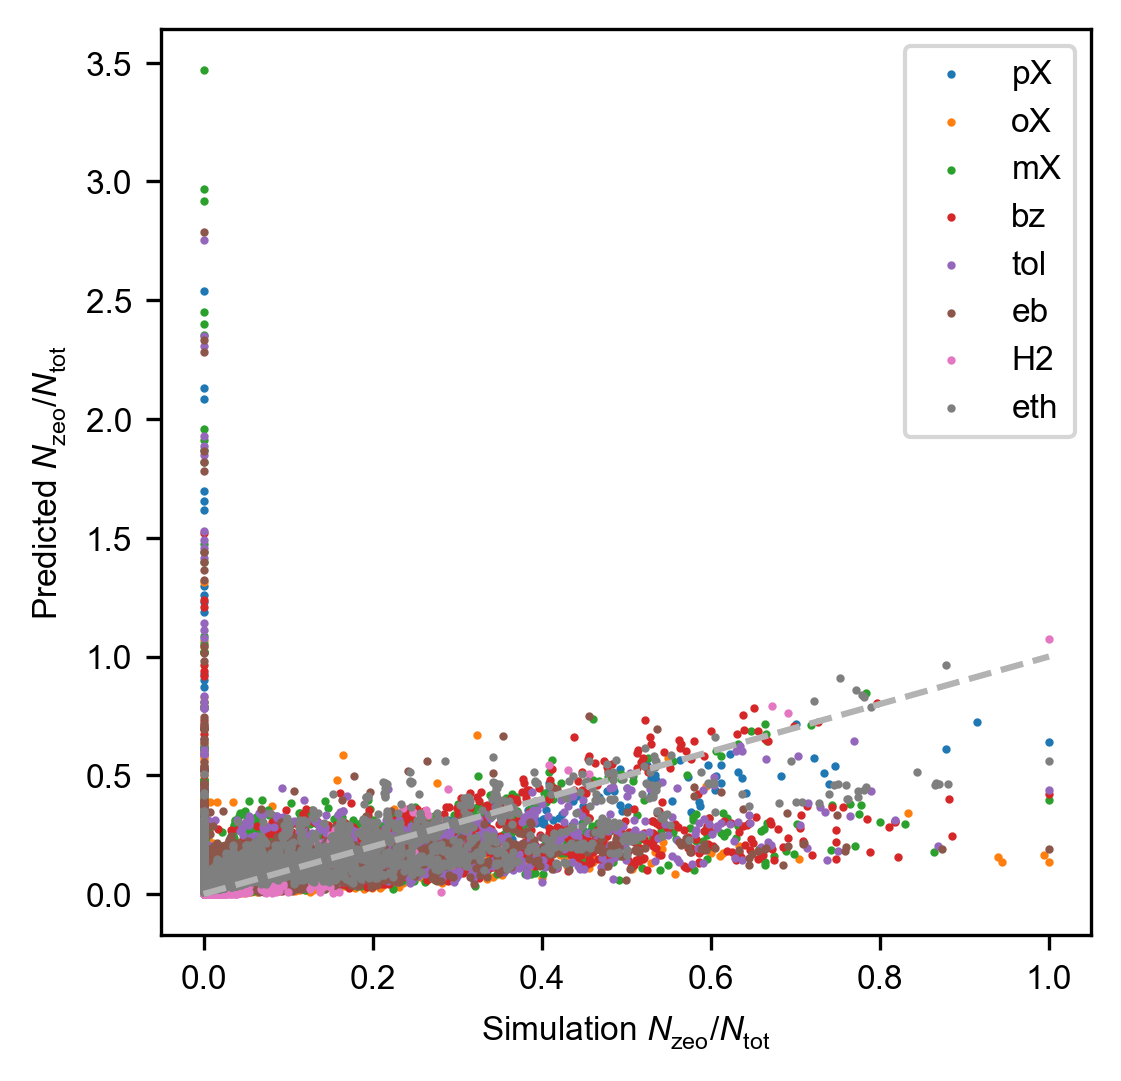

In [83]:
molecules = ['pX', 'oX', 'mX', 'bz', 'tol', 'eb', 'H2', 'eth']
loader = DataLoader(data_train, batch_size=len(data_train), num_workers=8, shuffle=True, pin_memory=True)
with torch.no_grad():
    for batch in loader:   
        x, y_true = batch
        x, y_true = x.to(device), y_true.to(device)
        y_pred, _, _ = net(x)
        #y_pred = torch.sigmoid(y_pred).cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        y_true = y_true.cpu().numpy()
print('Normalized MSE:', np.mean((y_pred - y_true) ** 2, axis=0) / np.max(y_true, axis=0) ** 2)
plt.figure(figsize=(4,4), dpi=300)


#y_true = np.log(y_true / (1 - y_true))
#y_pred = np.log(y_pred / (1 - y_pred))
#y_pred = 1 / (1 + np.exp(-y_pred))

for i in range(y_pred.shape[1]):
    plt.scatter(y_true[:, i], y_pred[:, i], s=1)
plt.legend(molecules)
plt.plot([0, 1], [0, 1], ls='--', color='0.7')
#plt.ylim([0, 1])
plt.xlabel('Simulation $N_\mathrm{zeo}/N_\mathrm{tot}$')
plt.ylabel('Predicted $N_\mathrm{zeo}/N_\mathrm{tot}$')
plt.show()

Normalized MSE: [1.4143465e-02 9.8185927e-02 7.2738186e-02 8.7247264e-01 8.3553392e-01
 3.8516897e-01 8.5331161e+01 2.5389355e-01]


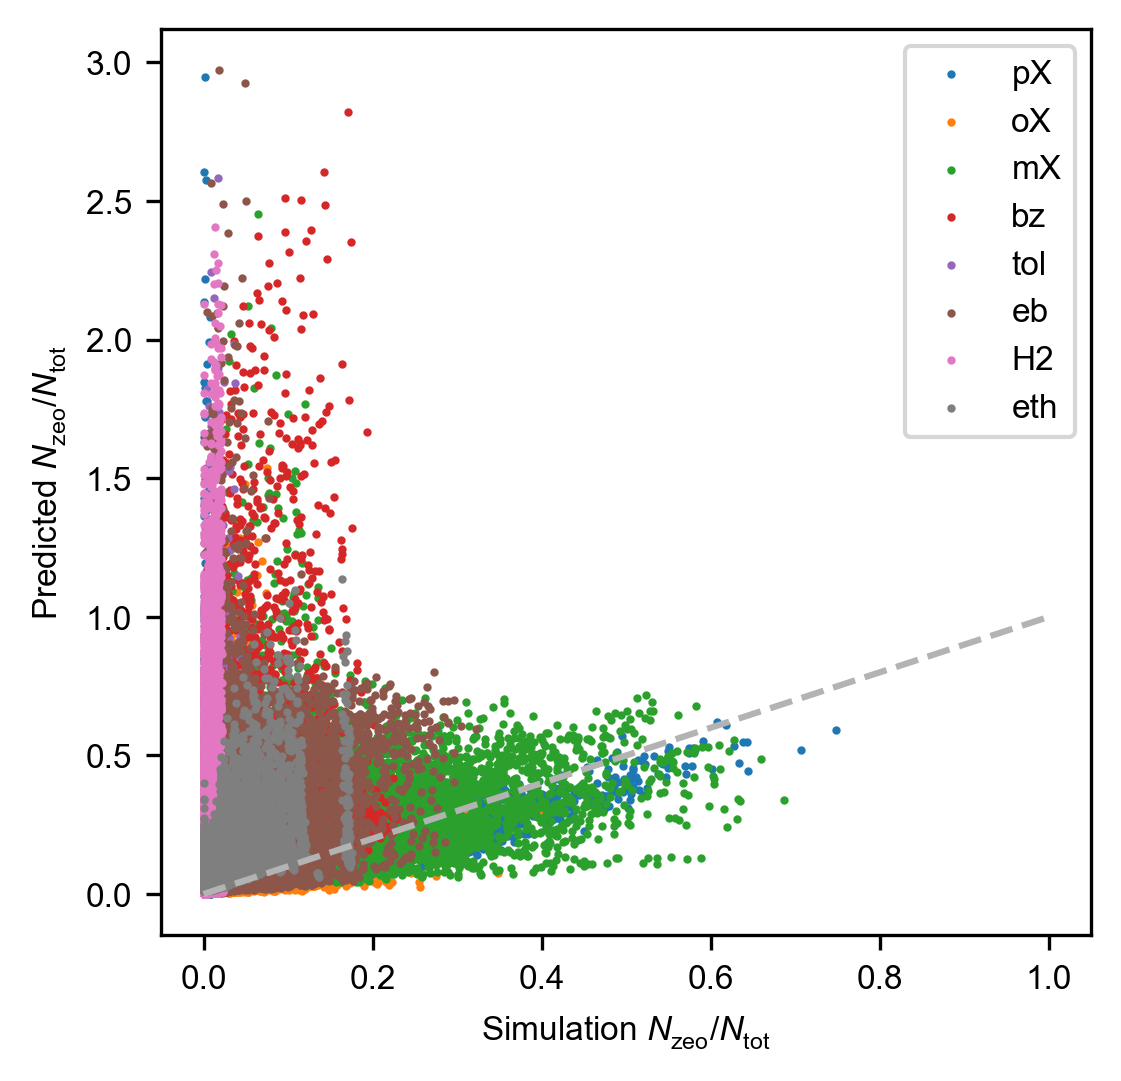

In [84]:
molecules = ['pX', 'oX', 'mX', 'bz', 'tol', 'eb', 'H2', 'eth']
testloader = DataLoader(data_test, batch_size=len(data_test), num_workers=8, shuffle=True, pin_memory=True)
with torch.no_grad():
    for batch in testloader:   
        x, y_true = batch
        x, y_true = x.to(device), y_true.to(device)
        y_pred, _, _ = net(x)
        #y_pred = torch.sigmoid(y_pred).cpu().numpy()
        y_pred = y_pred.cpu().numpy()
        y_true = y_true.cpu().numpy()
print('Normalized MSE:', np.mean((y_pred - y_true) ** 2, axis=0) / np.max(y_true, axis=0) ** 2)
plt.figure(figsize=(4,4), dpi=300)
#np.savetxt("mlp-test.txt", np.hstack([y_true, y_pred]))
#y_true = np.log(y_true / (1 - y_true))
#y_pred = np.log(y_pred / (1 - y_pred))
#y_pred = 1 / (1 + np.exp(-y_pred))

for i in range(y_pred.shape[1]):
    plt.scatter(y_true[:, i], y_pred[:, i], s=1)
plt.legend(molecules)
plt.plot([0, 1], [0, 1], ls='--', color='0.7')
#plt.ylim([0, 1])
plt.xlabel('Simulation $N_\mathrm{zeo}/N_\mathrm{tot}$')
plt.ylabel('Predicted $N_\mathrm{zeo}/N_\mathrm{tot}$')
plt.show()

In [13]:
results = {'loss': [], 'val_loss': [], 'val_mse': [], 'weights_v': [], 'weights_c': []}
for n in range(1, 12):
    net = MultiSorbNet(ncomp, states.shape[-1], nsites=n)
    net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr_init)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=lr_decay)
    train_loss, val_loss, val_mse = train(net, 200, 199, verbose=False)
    wv, = list(net.attn.attnblock.layer_v.parameters())
    results['loss'].append(train_loss)
    results['val_loss'].append(val_loss)
    results['val_mse'].append(val_mse)
    results['weights_v'].append(wv)

Epoch 0
Training loss: 6.901573e-03
Test loss: 3.414236e-03
Test MSE: 3.414236e-03
Epoch 199
Training loss: 2.690379e-04
Test loss: 3.276292e-04
Test MSE: 3.276292e-04
Epoch 0
Training loss: 5.192889e-03
Test loss: 3.456433e-03
Test MSE: 3.456433e-03
Epoch 199
Training loss: 2.490501e-04
Test loss: 2.178751e-04
Test MSE: 2.178751e-04
Epoch 0
Training loss: 5.250142e-03
Test loss: 3.289514e-03
Test MSE: 3.289514e-03
Epoch 199
Training loss: 9.163142e-05
Test loss: 4.929680e-05
Test MSE: 4.929680e-05
Epoch 0
Training loss: 5.452898e-03
Test loss: 2.640732e-03
Test MSE: 2.640732e-03
Epoch 199
Training loss: 1.030874e-04
Test loss: 5.072646e-05
Test MSE: 5.072646e-05
Epoch 0
Training loss: 5.181161e-03
Test loss: 3.995318e-03
Test MSE: 3.995318e-03
Epoch 199
Training loss: 7.565299e-05
Test loss: 4.352880e-05
Test MSE: 4.352880e-05
Epoch 0
Training loss: 5.619094e-03
Test loss: 3.553240e-03
Test MSE: 3.553240e-03
Epoch 199
Training loss: 1.015096e-04
Test loss: 4.833305e-05
Test MSE: 4.833

In [20]:
for n in [2]:
    net = MultiSorbNet(ncomp, states.shape[-1], nsites=n)
    net.to(device)
    opt = torch.optim.Adam(net.parameters(), lr=lr_init)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=lr_decay)
    train_loss, val_loss, val_mse = train(net, 200, 199, verbose=False)
    wv, = list(net.attn.attnblock.layer_v.parameters())
    results['loss'][n - 1] = train_loss
    results['val_loss'][n - 1] = val_loss
    results['val_mse'][n - 1] = val_mse
    results['weights_v'][n - 1] = wv

Epoch 0
Training loss: 6.891366e-03
Test loss: 4.120355e-03
Test MSE: 4.120355e-03
Epoch 199
Training loss: 9.984343e-05
Test loss: 6.618359e-05
Test MSE: 6.618359e-05


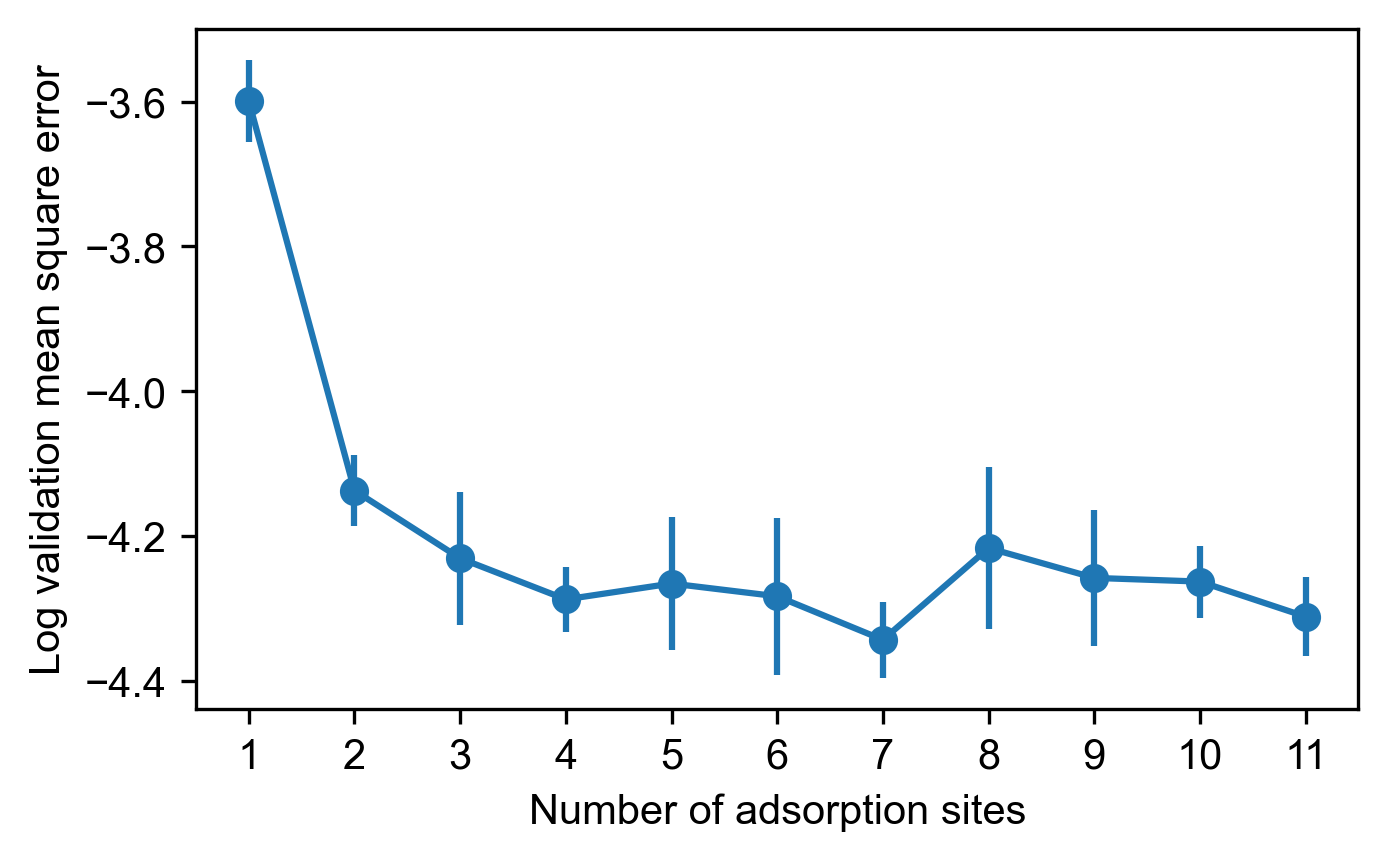

In [26]:
plt.figure(figsize=(5, 3), dpi=300)
lmse = np.log10(np.array(results['val_mse'])[:, -8:])
plt.errorbar(np.arange(1, 12), np.mean(lmse, axis=1),
             yerr = np.std(lmse, axis=1),
        marker='o')
plt.xlabel("Number of adsorption sites")
plt.ylabel("Log validation mean square error")
plt.xticks(np.arange(1, 12))
plt.show()

In [ ]:
nsites = 8
wv = results['weights_v'][nsites-1].view(nsites, ncomp, ncomp).detach().cpu().numpy()
print(results['weights_c'][nsites-1])

for i in range(nsites):
    if i % 8 == 0:
        plt.figure(figsize=(20, 3), dpi=400)
    plt.subplot(181+i % 8)
    plt.xticks(range(8), molecules)
    plt.yticks(range(8), molecules)
    plt.imshow(wv[i, :, :] + np.eye(8))
    if i % 8 == 7 or i == nsites - 1:
        plt.show()

In [ ]:
pca = PCA(8)
wt = pca.fit_transform((wv + np.eye(8)).reshape(nsites, -1).T)
print(wv.shape)
print(pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_))
plt.figure(figsize=(12, 1.5), dpi=400)
for i in range(8):
    plt.subplot(181+i)
    plt.imshow(np.abs(wt.T.reshape((-1, 8, 8))[i, :, :]))
plt.show()